In [75]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import seaborn as sns

train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

In [7]:
train.head(1)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,20.0,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.66833,0.00166,3.048333


In [8]:
train

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,20.0,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,20.0,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,20.0,...,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,10.0,33,1490,10.0,...,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,RU,NNC2,Container,8.813725,2022-08-13 12:57,D215135,30.0,10,27600,10.0,...,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,CN,YRT6,Bulk,59.018184,2017-11-11 22:23,J661243,40.0,13,93200,20.0,...,NaN,NaN,NaN,6,61.25,62.21,55.70,1333.609109,0.000360,65.850000
367437,JP,QYY1,Tanker,0.000000,2022-04-29 2:58,D847216,10.0,9,1280,0.0,...,0.87,17.1,1.028558,11,105.37,109.34,104.69,1955.103846,0.000552,0.000000
367438,SG,GIW5,Container,1.768630,2022-07-14 7:58,Q635545,30.0,6,25000,20.0,...,3.36,31.7,2.557156,15,97.73,99.10,95.78,1601.291086,0.002615,0.997500
367439,JP,TMR7,Cargo,0.000000,2020-12-22 10:07,N211282,10.0,8,2400,10.0,...,-2.44,10.8,3.055715,19,49.75,50.08,47.02,1191.353331,0.000069,0.000000


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367441 entries, 0 to 367440
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              367441 non-null  object 
 1   ARI_PO              367441 non-null  object 
 2   SHIP_TYPE_CATEGORY  367441 non-null  object 
 3   DIST                367441 non-null  float64
 4   ATA                 367441 non-null  object 
 5   ID                  367441 non-null  object 
 6   BREADTH             367440 non-null  float64
 7   BUILT               367441 non-null  int64  
 8   DEADWEIGHT          367441 non-null  int64  
 9   DEPTH               367440 non-null  float64
 10  DRAUGHT             367440 non-null  float64
 11  GT                  367441 non-null  int64  
 12  LENGTH              367440 non-null  float64
 13  SHIPMANAGER         367441 non-null  object 
 14  FLAG                367441 non-null  object 
 15  U_WIND              213955 non-nul

In [10]:
train.isna().sum()

ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
ID                         0
BREADTH                    1
BUILT                      0
DEADWEIGHT                 0
DEPTH                      1
DRAUGHT                    1
GT                         0
LENGTH                     1
SHIPMANAGER                0
FLAG                       0
U_WIND                153486
V_WIND                153486
AIR_TEMPERATURE       154365
BN                    153486
ATA_LT                     0
DUBAI                      0
BRENT                      0
WTI                        0
BDI_ADJ                    0
PORT_SIZE                  0
CI_HOUR                    0
dtype: int64

In [11]:
train

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,20.0,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,20.0,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,20.0,...,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,10.0,33,1490,10.0,...,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,RU,NNC2,Container,8.813725,2022-08-13 12:57,D215135,30.0,10,27600,10.0,...,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,CN,YRT6,Bulk,59.018184,2017-11-11 22:23,J661243,40.0,13,93200,20.0,...,NaN,NaN,NaN,6,61.25,62.21,55.70,1333.609109,0.000360,65.850000
367437,JP,QYY1,Tanker,0.000000,2022-04-29 2:58,D847216,10.0,9,1280,0.0,...,0.87,17.1,1.028558,11,105.37,109.34,104.69,1955.103846,0.000552,0.000000
367438,SG,GIW5,Container,1.768630,2022-07-14 7:58,Q635545,30.0,6,25000,20.0,...,3.36,31.7,2.557156,15,97.73,99.10,95.78,1601.291086,0.002615,0.997500
367439,JP,TMR7,Cargo,0.000000,2020-12-22 10:07,N211282,10.0,8,2400,10.0,...,-2.44,10.8,3.055715,19,49.75,50.08,47.02,1191.353331,0.000069,0.000000


In [12]:
train.dropna()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,20.0,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,20.0,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,20.0,...,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,10.0,33,1490,10.0,...,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,RU,NNC2,Container,8.813725,2022-08-13 12:57,D215135,30.0,10,27600,10.0,...,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367434,CN,QQW1,Bulk,55.408765,2022-06-16 14:27,D236761,30.0,16,26500,10.0,...,0.96,28.2,2.651752,22,108.43,114.13,109.56,2067.433444,0.000595,83.960833
367437,JP,QYY1,Tanker,0.000000,2022-04-29 2:58,D847216,10.0,9,1280,0.0,...,0.87,17.1,1.028558,11,105.37,109.34,104.69,1955.103846,0.000552,0.000000
367438,SG,GIW5,Container,1.768630,2022-07-14 7:58,Q635545,30.0,6,25000,20.0,...,3.36,31.7,2.557156,15,97.73,99.10,95.78,1601.291086,0.002615,0.997500
367439,JP,TMR7,Cargo,0.000000,2020-12-22 10:07,N211282,10.0,8,2400,10.0,...,-2.44,10.8,3.055715,19,49.75,50.08,47.02,1191.353331,0.000069,0.000000


In [14]:
non_object_col = []

for col in train.columns:
    if train[col].dtype.name != 'object':
        non_object_col.append(col)

In [15]:
non_object_col

['DIST',
 'BREADTH',
 'BUILT',
 'DEADWEIGHT',
 'DEPTH',
 'DRAUGHT',
 'GT',
 'LENGTH',
 'U_WIND',
 'V_WIND',
 'AIR_TEMPERATURE',
 'BN',
 'ATA_LT',
 'DUBAI',
 'BRENT',
 'WTI',
 'BDI_ADJ',
 'PORT_SIZE',
 'CI_HOUR']

In [16]:
tmp = train[non_object_col].dropna()

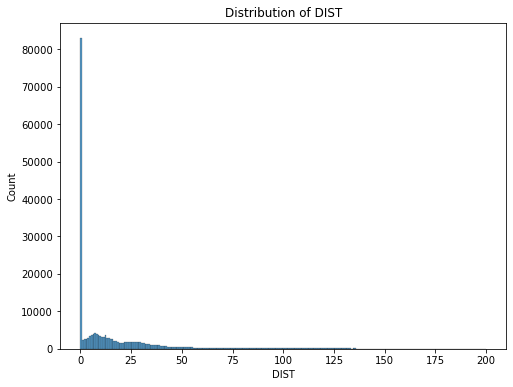

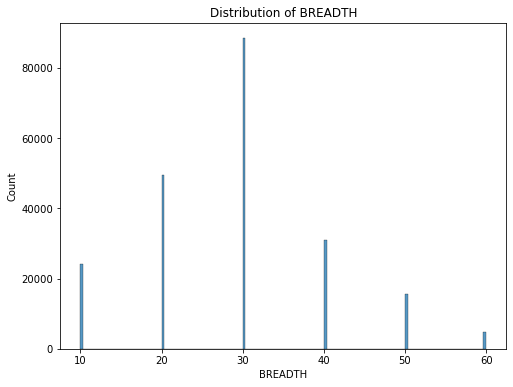

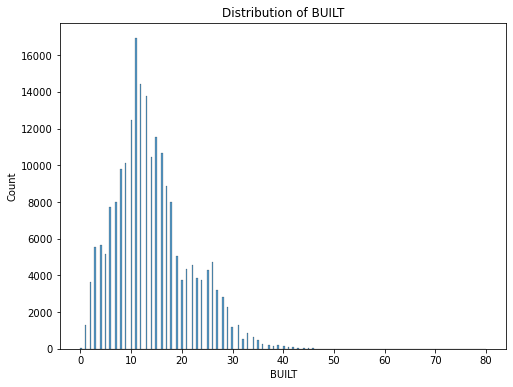

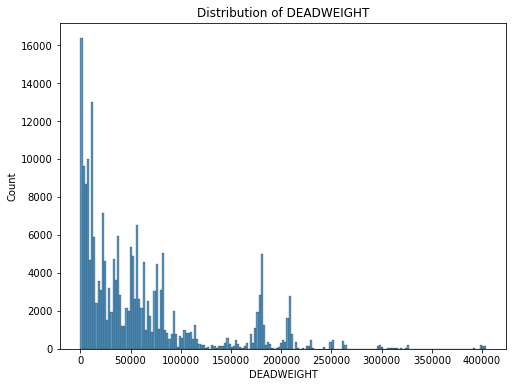

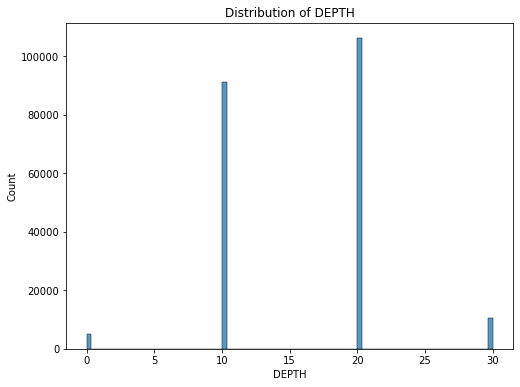

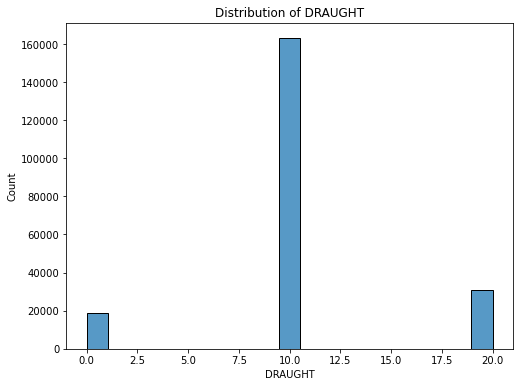

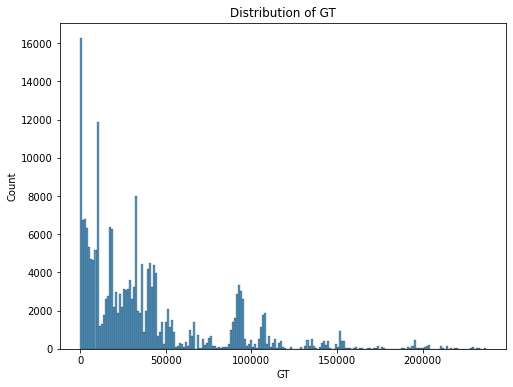

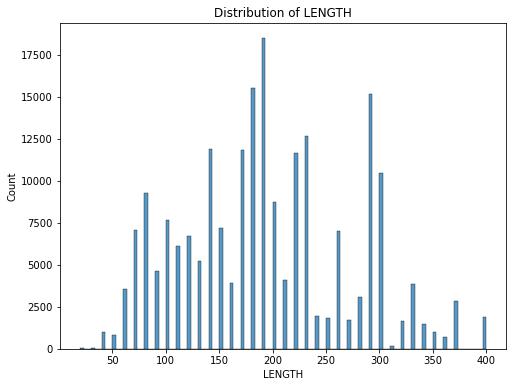

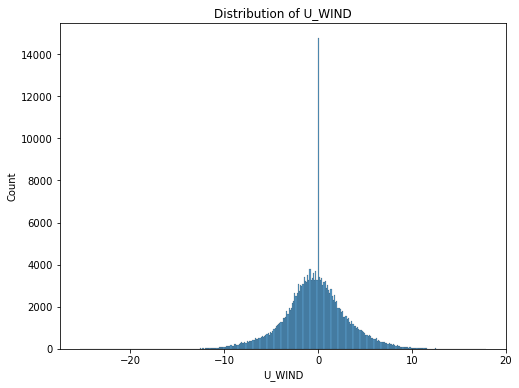

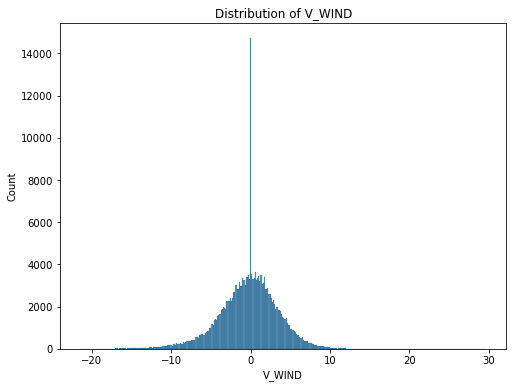

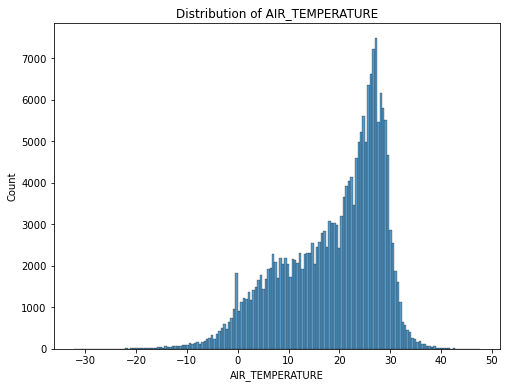

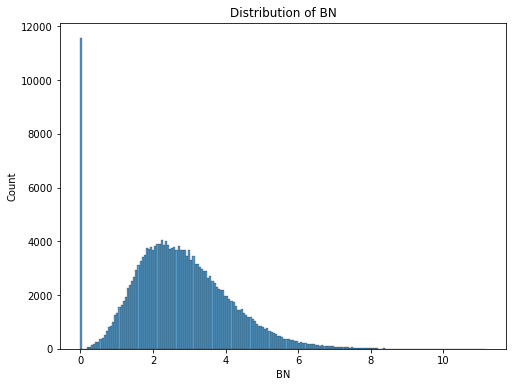

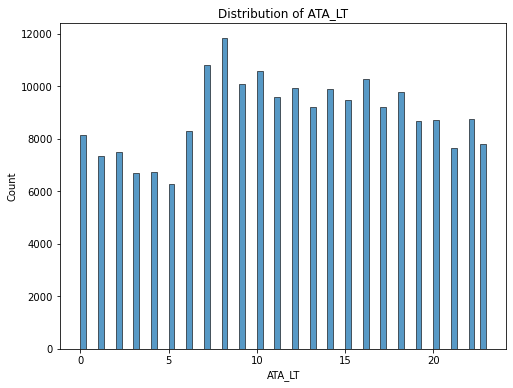

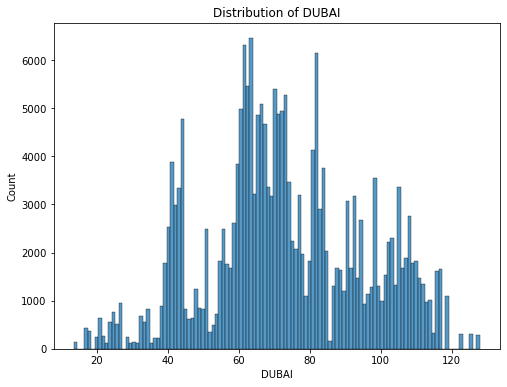

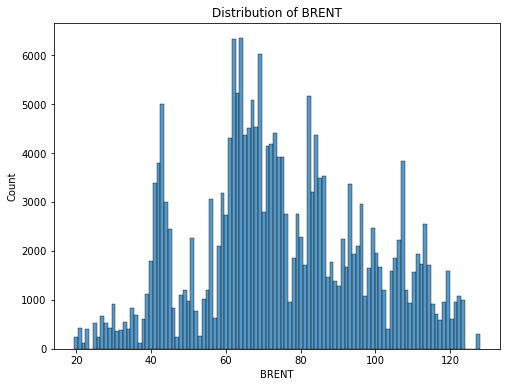

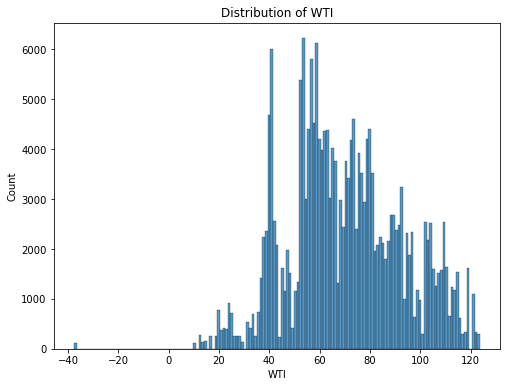

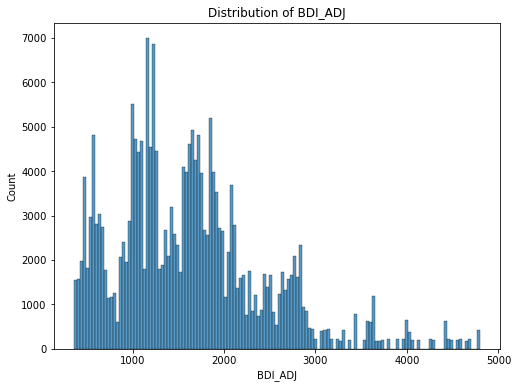

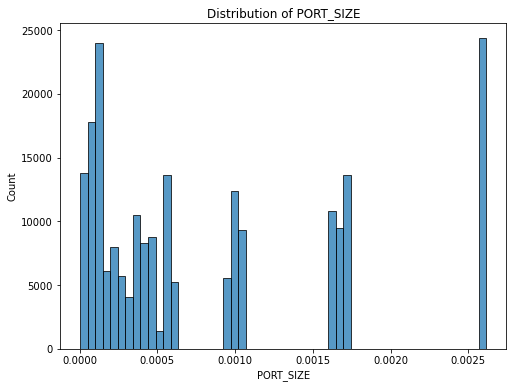

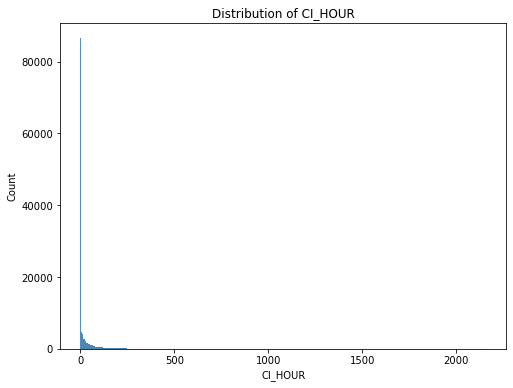

In [17]:
for col in non_object_col:
    plt.figure(figsize=(8, 6))  # 새로운 그림을 생성합니다.
    sns.histplot(x=tmp[col])  # 현재 칼럼에 대한 히스토그램을 그립니다.
    plt.title(f'Distribution of {col}')  # 그래프 제목을 설정합니다.
    plt.show()  # 그림을 화면에 출력합니다.

In [20]:
contin_train = train[non_object_col].dropna()

In [21]:
# DIST 0 분석
print(f"{len(contin_train[(contin_train.DIST == 0)])=}")
print(f"{len(contin_train[(contin_train.DIST == 0) & ~(contin_train.CI_HOUR == 0)])=}")
print(f"{len(contin_train[(contin_train.DIST == 0) & (contin_train.CI_HOUR == 0)])=}")

len(contin_train[(contin_train.DIST == 0)])=80293
len(contin_train[(contin_train.DIST == 0) & ~(contin_train.CI_HOUR == 0)])=23
len(contin_train[(contin_train.DIST == 0) & (contin_train.CI_HOUR == 0)])=80270


- DIST(정박지(ber_port)와 접안지 사이의 거리) = 0 -> 당연히 CI_HOUR == 0 이어야 하는데 
- DIST = 0 인데, CI_HOUR != 0인 경우 -> 23개 -> 다른 feature들에서 23개와 나머지의 분명한 차이가 있거나, 잘못 측정된 값일 수도

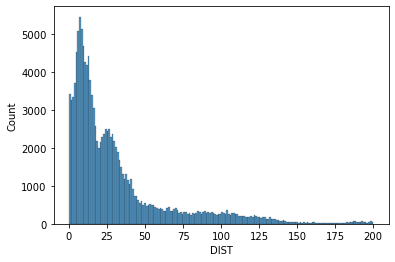

In [22]:
# DIST 0 제외하고 DIST plot하기
sns.histplot(x=contin_train[~(contin_train.DIST == 0)]['DIST'])

In [23]:
len(contin_train[(contin_train.DEADWEIGHT <= 10000)])

48067

In [24]:
len(contin_train)

213075

In [25]:
contin_train[(contin_train.U_WIND <= 0.5) & (contin_train.U_WIND >= 0)]

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,30.736578,30.0,28,73100,20.0,10.0,38600,220.0,0.14,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
2,90.427421,50.0,7,115000,20.0,10.0,96400,300.0,0.00,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
7,3.948892,30.0,10,28400,10.0,10.0,17000,170.0,0.00,0.00,21.8,0.000000,12,61.22,61.82,53.76,1084.553949,0.000479,31.208056
17,12.761741,20.0,11,7220,10.0,10.0,5910,120.0,0.47,-3.09,25.2,2.408865,1,89.80,92.65,85.83,1094.995837,0.002615,122.921389
24,6.450414,20.0,19,12600,10.0,10.0,9570,140.0,0.45,-1.07,-6.8,1.244595,12,90.42,90.78,89.36,1239.530083,0.000399,377.975833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367398,0.000000,20.0,11,11900,10.0,10.0,9890,150.0,0.00,0.00,17.2,0.000000,22,71.07,71.97,64.00,726.567468,0.000552,0.000000
367399,9.733672,20.0,34,5480,10.0,10.0,4110,100.0,0.00,0.00,10.1,0.000000,20,69.22,71.24,62.25,905.629735,0.000256,4.621944
367401,0.000000,30.0,10,26100,10.0,10.0,16100,160.0,0.00,0.00,22.4,0.000000,17,67.12,66.87,56.59,1008.604892,0.000264,0.000000
367407,19.039627,40.0,19,73200,20.0,10.0,65200,280.0,0.00,0.00,35.6,0.000000,9,71.63,72.18,63.60,947.923103,0.002615,289.962500


In [26]:
print(f"{len(contin_train[(contin_train.U_WIND == 0)])=}")
print(f"{len(contin_train[(contin_train.V_WIND == 0)])=}")
print(f"{len(contin_train[(contin_train.U_WIND == 0) & (contin_train.V_WIND == 0)])=}")
print(f"{len(contin_train[~(contin_train.U_WIND == 0) & (contin_train.V_WIND == 0)])=}")
print(f"{len(contin_train[(contin_train.U_WIND == 0) & ~(contin_train.V_WIND == 0)])=}")

len(contin_train[(contin_train.U_WIND == 0)])=11797
len(contin_train[(contin_train.V_WIND == 0)])=11773
len(contin_train[(contin_train.U_WIND == 0) & (contin_train.V_WIND == 0)])=11557
len(contin_train[~(contin_train.U_WIND == 0) & (contin_train.V_WIND == 0)])=216
len(contin_train[(contin_train.U_WIND == 0) & ~(contin_train.V_WIND == 0)])=240


In [27]:
contin_train[(contin_train.BN > 0) & (contin_train.BN < 1)]

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
41,0.000000,20.0,16,12100,10.0,10.0,9680,120.0,0.20,0.06,29.0,0.396605,18,79.57,82.56,78.93,4591.298598,0.000990,0.000000
57,0.000000,30.0,8,51100,20.0,10.0,30700,180.0,-0.13,0.51,5.1,0.734552,7,24.51,34.11,28.34,564.589694,0.000256,0.000000
70,4.104449,50.0,10,210000,20.0,20.0,107000,300.0,-0.52,0.21,7.7,0.766307,16,66.40,67.52,64.01,1684.323286,0.000479,28.005833
72,0.000000,20.0,25,10300,10.0,10.0,8310,140.0,-0.18,0.37,20.6,0.623373,6,73.43,75.19,73.08,2730.127968,0.000552,0.000000
85,12.831346,10.0,2,1700,10.0,0.0,500,60.0,0.65,0.28,16.7,0.894910,18,69.10,70.25,67.72,2227.826064,0.000479,36.974167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367238,0.000000,50.0,11,141000,30.0,20.0,142000,370.0,0.10,-0.28,27.3,0.501972,17,66.11,66.66,63.36,2449.106402,0.002615,0.000000
367269,9.988984,10.0,20,2400,10.0,10.0,1330,70.0,-0.35,-0.56,28.1,0.854524,4,113.21,117.98,111.76,1755.247808,0.000356,4.953056
367355,0.000000,30.0,4,62400,20.0,10.0,41400,200.0,0.62,-0.25,8.4,0.861521,21,108.58,110.23,104.24,1973.464626,0.000149,0.000000
367374,5.254744,10.0,16,2700,10.0,10.0,1990,80.0,-0.10,-0.64,15.2,0.843609,21,75.68,79.28,75.88,4415.591664,0.000128,9.346944


In [28]:
def calculate_B_from_V(V):
    B = (V / 0.836) ** (2/3)
    return B

contin_train['B'] = contin_train.BN.apply(lambda x:calculate_B_from_V(x))

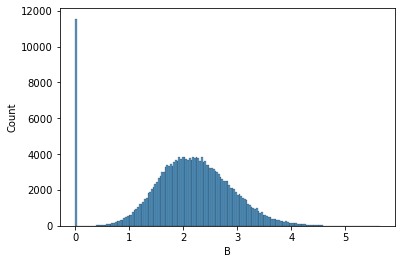

In [29]:
sns.histplot(x=contin_train['B'])

In [30]:
print(f"{len(contin_train[(contin_train['WTI'] < 0)])=}")
print(f"{len(contin_train[(contin_train['WTI'] < 0) & (contin_train['WTI'] == -37.63)])=}")

len(contin_train[(contin_train['WTI'] < 0)])=121
len(contin_train[(contin_train['WTI'] < 0) & (contin_train['WTI'] == -37.63)])=121


In [31]:
print(f"{len(contin_train[(contin_train['WTI'] < 0) & (contin_train['WTI'] == -37.63)])=}")

len(contin_train[(contin_train['WTI'] < 0) & (contin_train['WTI'] == -37.63)])=121


In [32]:
contin_train[(contin_train['WTI'] == -37.63)].DUBAI.unique()

array([20.78])

In [33]:
contin_train[(contin_train['WTI'] == -37.63)].BRENT.unique()

array([25.57])

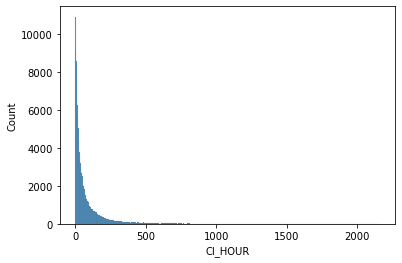

In [34]:
sns.histplot(x=contin_train[(contin_train['CI_HOUR'] != 0)].CI_HOUR)

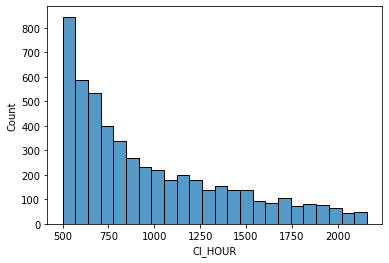

In [35]:
sns.histplot(x=contin_train[(contin_train['CI_HOUR'] >= 500)].CI_HOUR)

In [36]:
len(contin_train[(contin_train['CI_HOUR'] != 0)])

132805

# 결측치 채우기

In [76]:
test.isna().sum()

ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
ID                         0
BREADTH                    0
BUILT                      0
DEADWEIGHT                 0
DEPTH                      0
DRAUGHT                    0
GT                         0
LENGTH                     0
SHIPMANAGER                0
FLAG                       0
U_WIND                101927
V_WIND                101927
AIR_TEMPERATURE       102511
BN                    101927
ATA_LT                     0
DUBAI                      0
BRENT                      0
WTI                        0
BDI_ADJ                    0
PORT_SIZE                  0
dtype: int64

In [77]:
train.isna().sum()

ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
ID                         0
BREADTH                    1
BUILT                      0
DEADWEIGHT                 0
DEPTH                      1
DRAUGHT                    1
GT                         0
LENGTH                     1
SHIPMANAGER                0
FLAG                       0
U_WIND                153486
V_WIND                153486
AIR_TEMPERATURE       154365
BN                    153486
ATA_LT                     0
DUBAI                      0
BRENT                      0
WTI                        0
BDI_ADJ                    0
PORT_SIZE                  0
CI_HOUR                    0
dtype: int64

In [78]:
train[train.BREADTH.isna()].ID.values[0]

'A457875'

In [79]:
train[train.ID == train[train.BREADTH.isna()].ID.values[0]]

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
23856,TW,JWI3,Cargo,0.0,2022-11-08 4:10,A457875,NaN,28,1500,NaN,...,-1.91,25.3,1.752807,12,92.34,95.36,88.91,1065.911239,0.00099,0.0


In [80]:
train[train.BREADTH.isna()][['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH']]

,BREADTH,DEPTH,DRAUGHT,LENGTH
23856,NaN,NaN,NaN,NaN


In [81]:
train['BREADTH'].fillna(30.0, inplace=True)
train['DEPTH'].fillna(20.0, inplace=True)
train['DRAUGHT'].fillna(10.0, inplace=True)
train['LENGTH'].fillna(train['LENGTH'].mean(), inplace=True)

In [82]:
train.isna().sum()

ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
ID                         0
BREADTH                    0
BUILT                      0
DEADWEIGHT                 0
DEPTH                      0
DRAUGHT                    0
GT                         0
LENGTH                     0
SHIPMANAGER                0
FLAG                       0
U_WIND                153486
V_WIND                153486
AIR_TEMPERATURE       154365
BN                    153486
ATA_LT                     0
DUBAI                      0
BRENT                      0
WTI                        0
BDI_ADJ                    0
PORT_SIZE                  0
CI_HOUR                    0
dtype: int64

# 일부 칼럼 카테고리로 변경

In [83]:
train['BREADTH'] = train['BREADTH'].astype(str)

In [84]:
train['DEPTH'] = train['DEPTH'].astype(str)

In [85]:
train['DEPTH'] = train['DEPTH'].astype(str)

In [86]:
train['ATA_LT'] = train['ATA_LT'].astype(str)

# feature engineering

In [88]:
# domain based

train['DENSITY'] = train['DEADWEIGHT'] / train['GT']

In [89]:
def calculate_B_from_V(V):
    B = (V / 0.836) ** (2/3)
    return B

In [90]:
# B는 보퍼트 풍력 계급 기반의 계급

train['B'] = train.BN.apply(lambda x:calculate_B_from_V(x))

In [92]:
train.ATA

0          2020-10-15 4:03
1          2019-09-17 2:55
2          2019-02-23 6:43
3         2020-09-18 22:06
4         2022-08-13 12:57
                ...       
367436    2017-11-11 22:23
367437     2022-04-29 2:58
367438     2022-07-14 7:58
367439    2020-12-22 10:07
367440    2021-06-04 14:54
Name: ATA, Length: 367441, dtype: object

In [96]:
train['ATA'] = pd.to_datetime(train['ATA'])

train['YEAR'] = train['ATA'].dt.year
train['MONTH'] = train['ATA'].dt.month
train['HOUR'] = train['ATA'].dt.hour

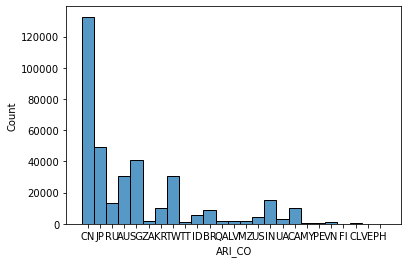

In [99]:
sns.histplot(x=train.ARI_CO)

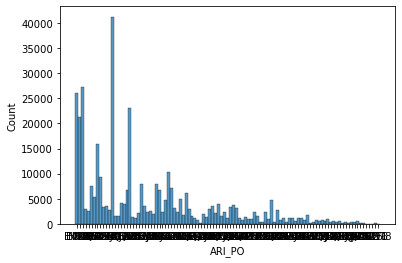

In [100]:
sns.histplot(x=train.ARI_PO)

In [ ]:
train.drop(labels=['ATA'], axis=1, inplace=True)

In [112]:
train.isna().sum()

ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ID                         0
BREADTH                    0
BUILT                      0
DEADWEIGHT                 0
DEPTH                      0
DRAUGHT                    0
GT                         0
LENGTH                     0
SHIPMANAGER                0
FLAG                       0
U_WIND                153486
V_WIND                153486
AIR_TEMPERATURE       154365
BN                    153486
ATA_LT                     0
DUBAI                      0
BRENT                      0
WTI                        0
BDI_ADJ                    0
PORT_SIZE                  0
CI_HOUR                    0
DENSITY                    0
B                     153486
YEAR                       0
MONTH                      0
HOUR                       0
dtype: int64

In [111]:
train.to_csv("./train_P0.csv", index=False)